In [1]:
import dask.dataframe as dd 
import numpy as np
from sklearn.preprocessing import LabelEncoder,RobustScaler,StandardScaler
import seaborn as sns
import featuretools as ft
from dask.distributed import Client
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score,roc_auc_score,recall_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from utils import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
bureau = dd.read_csv("../data/bureau.csv").compute()
a = bureau.shape
print("bureau shape :({},{})".format( a[0],a[1]))

bureau_balance= dd.read_csv("../data/bureau_balance.csv").compute()
a = bureau_balance.shape
print("bureau_balance shape :({},{})".format( a[0],a[1]))

credit_card_balance= dd.read_csv("../data/credit_card_balance.csv").compute()
a = credit_card_balance.shape
print("credit_card_balance shape :({},{})".format( a[0],a[1]))

installments_payments= dd.read_csv("../data/installments_payments.csv").compute()
a = installments_payments.shape
print("installments_payments shape :({},{})".format( a[0],a[1]))

previous_application= dd.read_csv("../data/previous_application.csv").compute()
a = previous_application.shape
print("previous_application shape :({},{})".format( a[0],a[1]))

POS_CASH_balance= dd.read_csv("../data/POS_CASH_balance.csv").compute()
a = POS_CASH_balance.shape
print("POS_CASH_balance shape :({},{})".format( a[0],a[1]))

application_train= dd.read_csv("../data/application_train.csv").compute()
a = application_train.shape
print("application_train shape :({},{})".format( a[0],a[1]))

application_test= dd.read_csv("../data/application_test.csv").compute()
a = application_test.shape
print("application_test shape :({},{})".format( a[0],a[1]))

bureau shape :(1716428,17)
bureau_balance shape :(27299925,3)
credit_card_balance shape :(3840312,23)
installments_payments shape :(13605401,8)
previous_application shape :(1670214,37)
POS_CASH_balance shape :(10001358,8)
application_train shape :(307511,122)
application_test shape :(48744,121)


<h1>Reduction Memoire</h1>

In [3]:
application_train=reduce_mem_usage(application_train)
bureau=reduce_mem_usage(bureau)
bureau_balance=reduce_mem_usage(bureau_balance)
credit_card_balance=reduce_mem_usage(credit_card_balance)
installments_payments=reduce_mem_usage(installments_payments)
previous_application=reduce_mem_usage(previous_application)
POS_CASH_balance=reduce_mem_usage(POS_CASH_balance)

Mem. usage decreased to 94.72 Mb (67.2% reduction)
Mem. usage decreased to 126.04 Mb (46.5% reduction)
Mem. usage decreased to 546.74 Mb (34.4% reduction)
Mem. usage decreased to 318.63 Mb (54.7% reduction)
Mem. usage decreased to 415.20 Mb (55.6% reduction)
Mem. usage decreased to 321.75 Mb (33.6% reduction)
Mem. usage decreased to 314.76 Mb (54.2% reduction)


<h1>Suppression outliers
</h1>

In [4]:
application_train=cleaning_application_train(application_train)
bureau=cleaning_bureau(bureau)
previous_application=cleaning_previous_application(previous_application)

<h1>Feature engineering</h1>

In [5]:
application_train=feature_engineering_application_train(application_train)
bureau=feature_engineering_bureau(bureau)
previous_application=feature_engineering_previous_application(previous_application)
POS_CASH_balance=feature_engineering_POS_CASH_balance(POS_CASH_balance)
credit_card_balance=feature_engineering_credit_card_balance(credit_card_balance)
installments_payments=feature_engineering_installments_payments(installments_payments)
bureau_balance=feature_engineering_bureau_balance(bureau_balance)

<h1>Jointure des tableaux</h1>

In [28]:
es = ft.EntitySet(id="application")
es = es.add_dataframe(dataframe_name="bureau",
                              dataframe=bureau,
                              index="SK_ID_BUREAU")

es = es.add_dataframe(dataframe_name="bureau_balance",
                              dataframe=bureau_balance,
                              index="index")

es = es.add_dataframe(dataframe_name="application_train",
                              dataframe=application_train,
                              index="SK_ID_CURR")

es = es.add_dataframe(dataframe_name="previous_application",
                              dataframe=previous_application,
                              index="SK_ID_PREV")

es = es.add_dataframe(dataframe_name="pos_cash_balance",
                              dataframe=POS_CASH_balance,
                              index="index")  

es = es.add_dataframe(dataframe_name="installments_payments",
                              dataframe=installments_payments,
                              index="index")

es = es.add_dataframe(dataframe_name="credit_card_balance",
                              dataframe=credit_card_balance,
                              index="index")                                                        

In [29]:
es

Entityset: application
  DataFrames:
    bureau [Rows: 1716428, Columns: 18]
    bureau_balance [Rows: 27299925, Columns: 4]
    application_train [Rows: 307511, Columns: 126]
    previous_application [Rows: 1670214, Columns: 38]
    pos_cash_balance [Rows: 10001358, Columns: 9]
    installments_payments [Rows: 13605401, Columns: 11]
    credit_card_balance [Rows: 3840312, Columns: 24]
  Relationships:
    No relationships

In [30]:
es = es.add_relationship("bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU")
es = es.add_relationship("application_train", "SK_ID_CURR", "bureau", "SK_ID_CURR")
es = es.add_relationship("application_train", "SK_ID_CURR", "installments_payments", "SK_ID_CURR")
es = es.add_relationship("application_train", "SK_ID_CURR", "credit_card_balance", "SK_ID_CURR")
es = es.add_relationship("application_train", "SK_ID_CURR", "pos_cash_balance", "SK_ID_CURR")
es = es.add_relationship("application_train", "SK_ID_CURR", "previous_application", "SK_ID_CURR")
# es = es.add_relationship("previous_application", "SK_ID_PREV", "installments_payments", "SK_ID_PREV")
# es = es.add_relationship("previous_application", "SK_ID_PREV", "credit_card_balance", "SK_ID_PREV")
# es = es.add_relationship("previous_application", "SK_ID_PREV", "pos_cash_balance", "SK_ID_PREV")

In [31]:
es

Entityset: application
  DataFrames:
    bureau [Rows: 1716428, Columns: 18]
    bureau_balance [Rows: 27299925, Columns: 4]
    application_train [Rows: 307511, Columns: 126]
    previous_application [Rows: 1670214, Columns: 38]
    pos_cash_balance [Rows: 10001358, Columns: 9]
    installments_payments [Rows: 13605401, Columns: 11]
    credit_card_balance [Rows: 3840312, Columns: 24]
  Relationships:
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    bureau.SK_ID_CURR -> application_train.SK_ID_CURR
    installments_payments.SK_ID_CURR -> application_train.SK_ID_CURR
    credit_card_balance.SK_ID_CURR -> application_train.SK_ID_CURR
    pos_cash_balance.SK_ID_CURR -> application_train.SK_ID_CURR
    previous_application.SK_ID_CURR -> application_train.SK_ID_CURR

In [32]:
feature_matrix, feature_defs =  ft.dfs(entityset=es, target_dataframe_name="application_train")

In [33]:
feature_matrix.to_csv("data.csv",index=False)

In [36]:
feature_matrix

NameError: name 'feature_matrix' is not defined

In [34]:
del application_train
del application_test
del bureau
del bureau_balance
del credit_card_balance
del POS_CASH_balance
del previous_application
del installments_payments
del feature_matrix

In [24]:
data=dd.read_csv("data.csv",dtype={'NUM_UNIQUE(pos_cash_balance.NAME_CONTRACT_STATUS)': 'float64',
       'NUM_UNIQUE(previous_application.CHANNEL_TYPE)': 'float64',
       'NUM_UNIQUE(previous_application.CODE_REJECT_REASON)': 'float64',
       'NUM_UNIQUE(previous_application.FLAG_LAST_APPL_PER_CONTRACT)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_CASH_LOAN_PURPOSE)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_CLIENT_TYPE)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_CONTRACT_STATUS)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_CONTRACT_TYPE)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_GOODS_CATEGORY)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_PAYMENT_TYPE)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_PORTFOLIO)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_PRODUCT_TYPE)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_SELLER_INDUSTRY)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_TYPE_SUITE)': 'float64',
       'NUM_UNIQUE(previous_application.NAME_YIELD_GROUP)': 'float64',
       'NUM_UNIQUE(previous_application.PRODUCT_COMBINATION)': 'float64',
       'NUM_UNIQUE(previous_application.WEEKDAY_APPR_PROCESS_START)': 'float64'}).compute()

In [25]:
data.shape

(307511, 705)

In [26]:
data_copy=data.copy()

<h1>Traitements des valeurs manquantes</h1>

In [27]:
categorical_features=data.select_dtypes('O').columns
numerical_features=data.select_dtypes(exclude="O").columns

In [28]:
len(categorical_features)+len(numerical_features)

705

In [29]:
for i in categorical_features:
        data_copy[i]=data_copy[i].fillna(data_copy[i].mode()[0]) 
for i in numerical_features:
        if(data_copy[i].mean()==np.nan):
            data_copy[i]=data_copy[i].fillna(data_copy[i].mean())
        else : 
            data_copy[i]=data_copy[i].fillna(0)

In [30]:
data_copy["TARGET"]

0        1
1        0
2        0
3        0
4        0
        ..
16162    0
16163    0
16164    0
16165    1
16166    0
Name: TARGET, Length: 307511, dtype: int64

In [31]:
infPos=[]
infNeg=[]
for i in numerical_features:
    if(data_copy[i].max()==np.inf):
        infPos.append(i)
    elif (data_copy[i].min()==-np.inf):
        infNeg.append(i)
for i in infPos:
    data_copy[i]=data_copy[i].replace(np.inf,np.nan)
    data_copy[i]=data_copy[i].replace(np.nan,data_copy[i].max())
for i in infNeg:
    data_copy[i]=data_copy[i].replace(-np.inf,np.nan)
    data_copy[i]=data_copy[i].replace(np.nan,data_copy[i].min())

In [32]:
data_copy["TARGET"]

0        1
1        0
2        0
3        0
4        0
        ..
16162    0
16163    0
16164    0
16165    1
16166    0
Name: TARGET, Length: 307511, dtype: int64

In [33]:
for i in numerical_features:
    if(data_copy[i].max()==np.inf):
        print(i)
    elif (data_copy[i].min()==-np.inf):
        print(i)

<h1>Encodage</h1>

In [34]:
for i in categorical_features:
        model=TargetEncoder(cols=[i])
        data_copy[i]=model.fit_transform(data_copy[i],data['TARGET'])

In [35]:
data_copy["TARGET"]

0        1
1        0
2        0
3        0
4        0
        ..
16162    0
16163    0
16164    0
16165    1
16166    0
Name: TARGET, Length: 307511, dtype: int64

<h1>Etude correlation</h1>

In [36]:
cor_matrix = data_copy.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data_copy.drop(to_drop,axis=1,inplace=True)

In [37]:
X=data_copy.drop(['TARGET'],axis=1)
y=data_copy['TARGET']

<h1>Selection des colonnes</h1>

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X,y)

RandomForestClassifier()

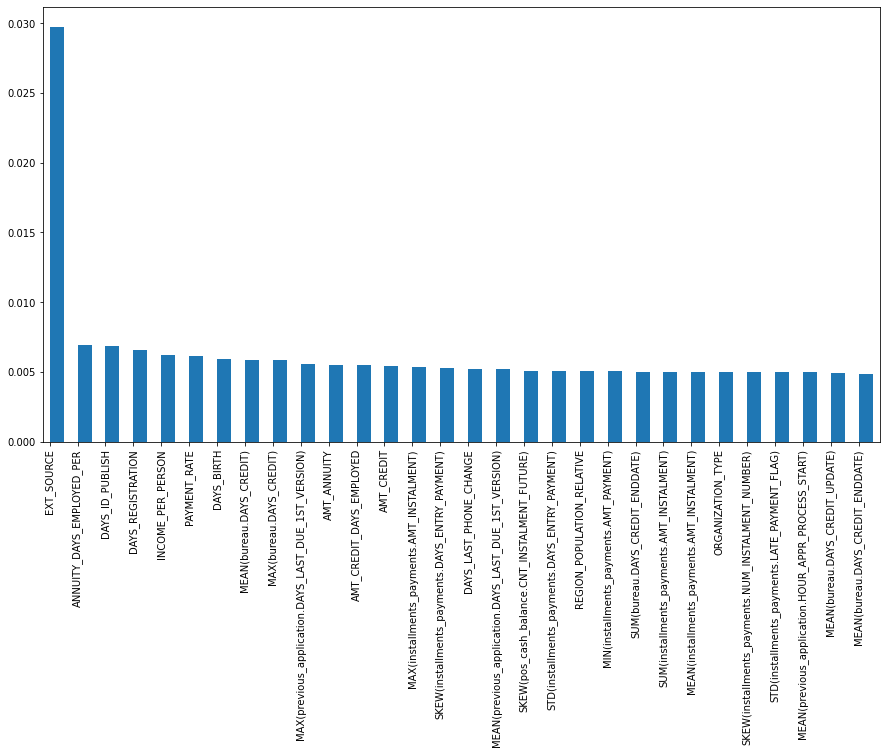

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
feature_importance= pd.Series(rfc.feature_importances_, index=data_copy.drop("TARGET",axis=1).columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

In [40]:
t=round(len(rfc.feature_importances_)*0.8)
keys= pd.Series(rfc.feature_importances_, index=data_copy.drop("TARGET",axis=1).columns).sort_values(ascending=False).head(t).keys()

In [46]:
data_copy=data_copy[keys]
data_copy["TARGET"]=y
data_copy.to_csv("data_clean.csv",index=False)

In [49]:
del data
del data_copy
del X 
del y